# FEMA Large Disasters with Demographics

In [145]:
import warnings
warnings.filterwarnings('ignore')

# Basic libraries
import geopandas as gpd
import pandas as pd
import numpy as np
import time

import seaborn as sns
import matplotlib.pyplot as plt

# Modeling
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, KFold

# Metrics
from sklearn import metrics
from sklearn.decomposition import PCA

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

### Load FEMA Data

In [2]:
# Load FEMA data
flData = pd.read_csv("../data/open-fema/FEMA-Large-DR-4337-FL.csv")
txData = pd.read_csv("../data/open-fema/FEMA-Large-DR-4332-TX.csv")
prData = pd.read_csv("../data/open-fema/FEMA-Large-DR-4339-PR.csv")

In [3]:
# Combine FL + PR + TX datasets
femaDf = pd.concat([flData, txData, prData])
print(f"There are {len(femaDf)} records in the dataframe.")

There are 4661523 records in the dataframe.


In [4]:
# Look at data types for each of the columns
femaDf.dtypes

disasterNumber                       int64
damagedCity                         object
damagedStateAbbreviation            object
damagedZipCode                     float64
householdComposition                 int64
grossIncome                        float64
specialNeeds                          bool
ownRent                             object
residenceType                       object
homeOwnersInsurance                   bool
floodInsurance                        bool
inspected                             bool
rpfvl                              float64
habitabilityRepairsRequired         object
destroyed                             bool
waterLevel                         float64
floodDamage                           bool
foundationDamage                      bool
foundationDamageAmount             float64
roofDamage                            bool
roofDamageAmount                   float64
tsaEligible                           bool
tsaCheckedIn                          bool
rentalAssis

In [5]:
femaDf.drop_duplicates(inplace=True)
print(f"There are {len(femaDf)} records after dropping any duplicates.")

There are 4661523 records after dropping any duplicates.


In [6]:
# Change incorrect datatype
femaDf['habitabilityRepairsRequired'] = femaDf['habitabilityRepairsRequired'].astype('bool')
femaDf['primaryResidence'] = femaDf['primaryResidence'].astype('bool')
femaDf['censusBlockId'] = femaDf['censusBlockId'].astype('str')
print(f"habitabilityRepairsRequired datatype: {femaDf['habitabilityRepairsRequired'].dtype}")
print(f"primaryResidence datatype: {femaDf['primaryResidence'].dtype}")
print(f"censusBlockId datatype: {femaDf['censusBlockId'].dtype}")

habitabilityRepairsRequired datatype: bool
primaryResidence datatype: bool
censusBlockId datatype: object


In [7]:
# Create census tract IDs for FEMA dataset
femaDf['censusTractId'] = femaDf.apply(lambda row: row.censusBlockId[0:11], axis=1)
femaDf[['censusBlockId', 'censusTractId']].head()

censusBlockId censusTractId
0  120111105011006.0   12011110501
1  120860011032003.0   12086001103
2  120830012043000.0   12083001204
3  120860135002000.0   12086013500
4  120090641241018.0   12009064124

### Combine Demographics with FEMA data

In [8]:
# Load demographics data
demoDf = pd.read_csv("../data/census-tract/census-tract-demographics-trim.csv")
demoDf.head(3)

censusid         gisjoin      tractid  \
0  1400000US12001000200  G1200010000200  12001000200   
1  1400000US12001000301  G1200010000301  12001000301   
2  1400000US12001000302  G1200010000302  12001000302   

                                    tractname          county    state  \
0     Census Tract 2, Alachua County, Florida  Alachua County  Florida   
1  Census Tract 3.01, Alachua County, Florida  Alachua County  Florida   
2  Census Tract 3.02, Alachua County, Florida  Alachua County  Florida   

   total_population  male_population  female_population  total_population_edu  \
0              6834             3096               3738                  1941   
1              3849             1806               2043                  2443   
2              2374             1151               1223                  1700   

   high_school_grad  bachelors_degree  graduate_prof_degree  \
0               564               256                   479   
1               467               570                   440   
2               464               246                   194   

   high_school_grad_rate  bachelors_degree_rate  graduate_prof_degree_rate  \
0               0.290572               0.131891                   0.246780   
1               0.191158               0.233320                   0.180106   
2               0.272941               0.144706                   0.114118   

   bachelors_plus_degree_rate  total_population_employ  labor_force_total  \
0                    0.378671                     6681               3151   
1                    0.413426                     3499               2397   
2                    0.258824                     2047               1241   

   civilian_labor_force  employed_labor_force  unemployed_labor_force  \
0                  3147                  2923                     224   
1                  2397                  2161                     236   
2                  1241                  1064                     177   

   armed_forces_labor_force  not_labor_force_total  labor_force_rate  \
0                         4                   3530          0.471636   
1                         0                   1102          0.685053   
2                         0                    806          0.606253   

   civilian_labor_rate  employed_labor_rate  unemployed_labor_rate  \
0             0.471037             0.437509               0.033528   
1             0.685053             0.617605               0.067448   
2             0.606253             0.519785               0.086468   

   armed_forces_labor_rate  not_labor_force_rate  total_population_income  \
0                 0.000599              0.528364                      345   
1                 0.000000              0.314947                      592   
2                 0.000000              0.393747                      433   

   income_less_10k  income_10k_15k  income_15k_20k  income_20k_25k  \
0               28              49              30               0   
1               55              71              12              63   
2                8              22              12             106   

   income_25k_30k  income_30k_35k  income_35k_40k  income_40k_45k  \
0               0              31               0               0   
1               5              10              53              39   
2              24              29              19               0   

   income_45k_50k  income_50k_60k  income_60k_75k  income_75k_100k  \
0               0              71              49               14   
1              66              55              24               86   
2              13              34              57               22   

   income_100k_125k  income_125k_150k  income_150k_200k  income_200k_more  \
0                21                30                22                 0   
1                 0                14                23                16   
2                41                23              

In [9]:
# Check vars in index
print(demoDf.columns)

Index(['censusid', 'gisjoin', 'tractid', 'tractname', 'county', 'state',
       'total_population', 'male_population', 'female_population',
       'total_population_edu',
       ...
       'total_foreign_rate', 'foreign_citizen_rate',
       'foreign_non_citizen_rate', 'poverty_rank', 'unemployed_rank',
       'earnings_rank', 'owner_rank', 'house_old_rank', 'dvi_raw', 'dvi'],
      dtype='object', length=328)


In [10]:
# Change to tractid datatype to string
demoDf['tractid'] = demoDf['tractid'].astype('str')
print(f"tractid datatype: {demoDf['tractid'].dtype}")

tractid datatype: object


In [11]:
# Select subset of variables
demoDf = demoDf[['censusid', 'tractid', 'tractname', 'county', 'state', 'below_poverty_rate', 'median_earnings_total',
                 'unemployed_labor_rate', 'built_1979_or_earlier_rate', 'owner_occupied_rate', 'dvi']]

demoDf.head(3)

censusid      tractid  \
0  1400000US12001000200  12001000200   
1  1400000US12001000301  12001000301   
2  1400000US12001000302  12001000302   

                                    tractname          county    state  \
0     Census Tract 2, Alachua County, Florida  Alachua County  Florida   
1  Census Tract 3.01, Alachua County, Florida  Alachua County  Florida   
2  Census Tract 3.02, Alachua County, Florida  Alachua County  Florida   

   below_poverty_rate  median_earnings_total  unemployed_labor_rate  \
0            0.561760                   6752               0.033528   
1            0.347230                  20481               0.067448   
2            0.244323                  25108               0.086468   

   built_1979_or_earlier_rate  owner_occupied_rate       dvi  
0                    0.412270             0.176396  0.632103  
1                    0.630089             0.205597  0.719638  
2                    0.834117             0.425976  0.740157

In [12]:
# Merge demographics and FEMA datasets
df = pd.merge(femaDf, demoDf, left_on='censusTractId', right_on='tractid')

In [13]:
# Check how many rows we have in the merged dataframe
print(f"There are {len(df)} records in the merged dataset.")
print(f"This is a {len(femaDf) - len(df)} difference b/w the original dataset and the merged.")

There are 4599003 records in the merged dataset.
This is a 62520 difference b/w the original dataset and the merged.


In [14]:
# Check how many census tracts are represented between TX & FL
print(f"There are {len(df['tractid'].unique())} tracts represented in the dataset.")
print(f"Of these, {len(df.loc[df['damagedStateAbbreviation'] == 'PR', 'censusid'].unique())} are from PR.")
print(f"Of these, {len(df.loc[df['damagedStateAbbreviation'] == 'TX', 'censusid'].unique())} are from TX.")
print(f"Of these, {len(df.loc[df['damagedStateAbbreviation'] == 'FL', 'censusid'].unique())} are from FL.")

There are 7461 tracts represented in the dataset.
Of these, 884 are from PR.
Of these, 2453 are from TX.
Of these, 4127 are from FL.


In [15]:
# Define all dollar amount columns
amountCols = ['foundationDamageAmount', 'roofDamageAmount', 'rentalAssistanceAmount', 
              'replacementAmount','repairAmount', 'rpfvl', 'ppfvl']

# Set them to zero if null
df[amountCols] = df[amountCols].fillna(0)

# Calculate the aggregated haAmount
df['haAmount'] = df['rentalAssistanceAmount'] + df['replacementAmount'] + df['repairAmount']

print('Total ${:,.2f} in HA payouts'.format(df['haAmount'].sum()))
print('Total ${:,.2f} in mainland HA payouts'.format(df.loc[df['damagedStateAbbreviation'] != 'PR', 'haAmount'].sum()))

Total $2,578,826,315.71 in HA payouts
Total $1,930,647,257.50 in mainland HA payouts


In [16]:
# Drop the individual amount columns
femaDf.drop(['rentalAssistanceAmount', 'replacementAmount','repairAmount'], axis=1, inplace=True)

### Feature Engineering

In [17]:
# Convert boolean columns to int
bool_cols = ['specialNeeds', 'homeOwnersInsurance', 'floodInsurance', 'inspected', 'destroyed', 
             'habitabilityRepairsRequired', 'floodDamage', 'foundationDamage', 'roofDamage', 
             'tsaEligible', 'rentalAssistanceEligible', 'repairAssistanceEligible', 
             'replacementAssistanceEligible', 'sbaEligible', 'primaryResidence']

df[bool_cols] = df[bool_cols].astype(int)

In [18]:
# Fill the na's with zero's in waterLevel 
df['waterLevel'].fillna(0, inplace=True)

In [19]:
# One-hot encode the categorical variables
cat_cols = ['ownRent', 'residenceType']
for col in cat_cols:
    df = pd.concat([df, pd.get_dummies(df[col], prefix=col)], axis=1)
df.drop(cat_cols, axis=1, inplace=True)

In [20]:
# Write to csv
df.to_csv("../data/open-fema/FEMA-Large-Demographics.csv", index=False, encoding='utf-8')

## Dimensionality Reduction

In [33]:
# Load Full data
df = pd.read_csv("../data/open-fema/FEMA-Large-Demographics.csv")

# Define columns
cols = ['householdComposition', 'specialNeeds', 'homeOwnersInsurance', 'floodInsurance', 'inspected',
        'rpfvl', 'habitabilityRepairsRequired', 'destroyed', 'waterLevel', 'floodDamage',
        'foundationDamage', 'roofDamage', 'tsaEligible', 'rentalAssistanceEligible', 'repairAssistanceEligible',
        'replacementAssistanceEligible', 'sbaEligible', 'primaryResidence', 'haAmount', 'ownRent_Owner',
        'ownRent_Renter', 'ownRent_Unknown', 'residenceType_Apartment', 'residenceType_Assisted Living Facility',
        'residenceType_Boat', 'residenceType_College Dorm', 'residenceType_Condo',
        'residenceType_Correctional Facility', 'residenceType_House/Duplex', 'residenceType_Military Housing',
        'residenceType_Mobile Home', 'residenceType_Other', 'residenceType_Townhouse',
        'residenceType_Travel Trailer' ,'residenceType_Unknown', 'below_poverty_rate', 'median_earnings_total',
        'unemployed_labor_rate', 'built_1979_or_earlier_rate', 'owner_occupied_rate', 'dvi']

In [34]:
# Create train/test
trainDf = df.loc[df['damagedStateAbbreviation'] != 'PR', cols]
testDf = df.loc[df['damagedStateAbbreviation'] == 'PR', cols]

# Convert numpy arrays
X_train = np.array(trainDf.loc[:, trainDf.columns != 'haAmount'])
y_train = np.array(trainDf.loc[:, 'haAmount'])

X_test = np.array(testDf.loc[:, testDf.columns != 'haAmount'])
y_test = np.array(testDf.loc[:, 'haAmount'])

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(3533663, 40) (3533663,)
(1065340, 40) (1065340,)


### Principal Components Analysis

In [35]:
def pca_plots(data, color):

    n_components = np.arange(1,7)
    individuals = []
    cumulatives = []

    # Fit Principal Component Analysis (PCA) 
    pca = PCA(n_components=6)
    pca.fit(data)

    # Cumulative sum of variance explained for each n_compoents
    for i, n in enumerate(n_components):
        individuals.append(pca.explained_variance_ratio_[i])
        cumulative = np.sum(pca.explained_variance_ratio_[:n])
        cumulatives.append(cumulative)
        print('#{}: {:.5f}'.format(n, pca.explained_variance_ratio_[i]))

    # Plot explained variance by individual component
    fig, axes = plt.subplots(1,2, figsize = (14,4))

    axes[0].bar(n_components, individuals, color=color)
    axes[0].set_title('Explained Variance by N Principal Components')
    axes[0].set_ylabel('Explained variance ratio')
    axes[0].set_xlabel('Principal components')

    # Plot cumulative explained variance
    axes[1].plot(n_components, cumulatives, color=color)
    axes[1].set_title('Cumulative Explained Variance by N Components')
    axes[1].set_ylabel('Explained variance ratio')
    axes[1].set_xlabel('Principal components')

#1: 0.89909
#2: 0.10091
#3: 0.00000
#4: 0.00000
#5: 0.00000
#6: 0.00000


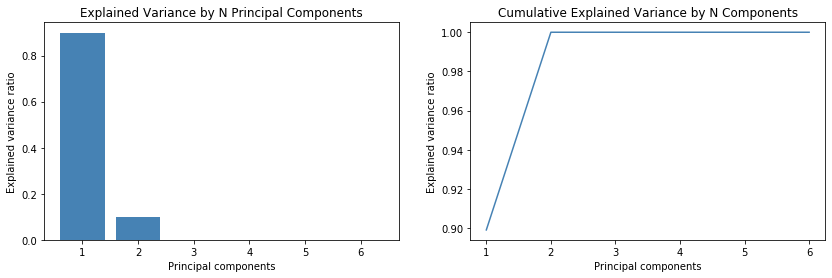

In [36]:
# Train plots
pca_plots(X_train, color = 'steelblue')

#1: 0.81600
#2: 0.18400
#3: 0.00000
#4: 0.00000
#5: 0.00000
#6: 0.00000


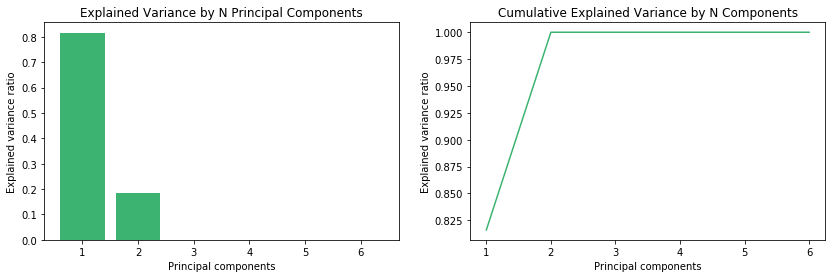

In [37]:
# Combine train/test to check for shift
X_full = np.concatenate((X_train, X_test), axis=0)

# Full plots
pca_plots(X_full, color = 'mediumseagreen')

### Full Data - Covariate Shift Check

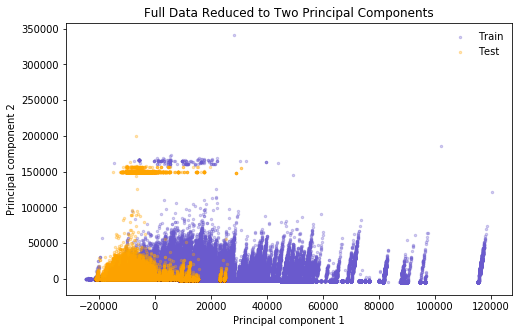

In [38]:
def reduced_dim_plot():

    # PCA full data - 2-dims
    pca = PCA(n_components=2)
    full_pca = pca.fit_transform(X_full)

    # Length for split
    cut = np.shape(X_train)[0]

    # Split full PCA into train-test
    train_pca = full_pca[:cut]
    test_pca = full_pca[cut:]

    # Plot train-test types
    fig, ax = plt.subplots(figsize = (8,5))
    plt.scatter(train_pca[:,0], train_pca[:,1], color='slateblue', s=6, alpha=0.3, label='Train')
    plt.scatter(test_pca[:,0], test_pca[:,1], color='orange', s=6, alpha=0.3, label='Test')

    ax.set_title('Full Data Reduced to Two Principal Components')
    plt.xlabel('Principal component 1')
    plt.ylabel('Principal component 2')
    plt.legend(loc='upper right', frameon=False)
    
reduced_dim_plot()

### Florida-Texas - Covariate Check

In [39]:
# Create train/test
trainFlDf = trainDf.loc[df['damagedStateAbbreviation'] == 'FL', cols]
testTxDf = trainDf.loc[df['damagedStateAbbreviation'] == 'TX', cols]

# Convert numpy arrays
X_trainFl = np.array(trainFlDf.loc[:, trainFlDf.columns != 'haAmount'])
y_trainFl = np.array(trainFlDf.loc[:, 'haAmount'])

X_testTx = np.array(testTxDf.loc[:, testTxDf.columns != 'haAmount'])
y_testTx = np.array(testTxDf.loc[:, 'haAmount'])

# Combine FL/TX to check for shift
X_full_FlTx = np.concatenate((X_trainFl, X_testTx), axis=0)

print(X_trainFl.shape, y_trainFl.shape)
print(X_testTx.shape, y_testTx.shape)

(2639073, 40) (2639073,)
(894590, 40) (894590,)


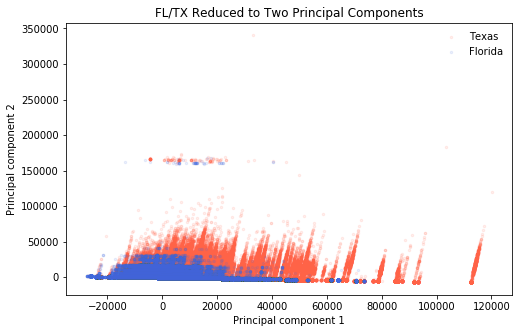

In [40]:
def reduced_FL_TX_plot():

    # PCA full data - 2-dims
    pca = PCA(n_components=2)
    full_pca = pca.fit_transform(X_full_FlTx)

    # Length for split
    cut = np.shape(X_trainFl)[0]

    # Split full PCA into train-test
    train_pca = full_pca[:cut]
    test_pca = full_pca[cut:]

    # Plot train-test types
    fig, ax = plt.subplots(figsize = (8,5))
    plt.scatter(test_pca[:,0], test_pca[:,1], color='tomato', s=6, alpha=0.1, label='Texas')
    plt.scatter(train_pca[:,0], train_pca[:,1], color='royalblue', s=6, alpha=0.1, label='Florida')

    ax.set_title('FL/TX Reduced to Two Principal Components')
    plt.xlabel('Principal component 1')
    plt.ylabel('Principal component 2')
    plt.legend(loc='upper right', frameon=False)
    
reduced_FL_TX_plot()

### Dependent Variable

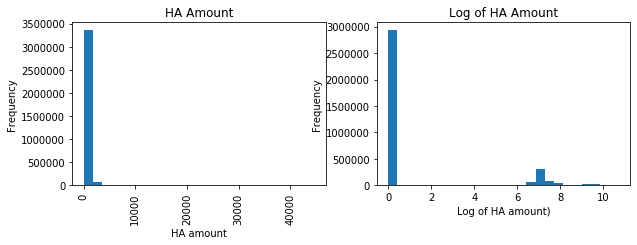

In [41]:
def plot_ha_amount(train=trainDf):
    '''Plots the distribution of HA Amount (dependent variable).
    Accepts dataframe as input.  Displays distribution of HA
    Amount (untransformed) and transformed logarithmically.
    '''
    # Define figure
    fig, axes = plt.subplots(1,2, figsize = (10,3))

    # Histogram of sale price
    axes[0].hist(train.haAmount, bins=25)
    axes[0].set_title('HA Amount')
    axes[0].set_xlabel('HA amount')
    axes[0].set_ylabel('Frequency')

    # Rotate x labels
    for tick in axes[0].get_xticklabels():
        tick.set_rotation(90)

    # Histogram of log(sale price) 
    axes[1].hist(np.log1p(train.haAmount), bins=25)
    axes[1].set_title('Log of HA Amount')
    axes[1].set_xlabel('Log of HA amount)')
    axes[1].set_ylabel('Frequency')

plot_ha_amount()

## Modeling

In [57]:
# Load Full data
fullDf = pd.read_csv("../data/open-fema/FEMA-Large-Demographics.csv")

# Keep FL/TX only
df = fullDf.loc[df['damagedStateAbbreviation'] != 'PR', ]

In [69]:
def adaboost_regressor(full_data=df):
    
    # Split the data into train and test data
    X = full_data.loc[:, full_data.columns != 'haAmount']
    y = full_data.loc[:, 'haAmount']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = True, random_state=7)

    # AdaBoost - fit the model
    ada = AdaBoostRegressor(random_state=0, n_estimators=100)
    ada.fit(X_train, y_train)

    # Predict
    y_pred = ada.predict(X_test)
    
    # Parameters and results
    print('AdaBoost Regressor')
    print('Features: {}'.format(full_data.shape[1]))
    print('R^2: {:.4f}'.format(ada.score(X_train, y_train)))
    print('MAE: {:.2f}'.format(metrics.mean_absolute_error(y_test, y_pred)))
    print('MSE: {:.2f}'.format(metrics.mean_squared_error(y_test, y_pred)))
    print('RMSE: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_test, y_pred))))
    
    return(ada)

### FEMA Only

In [72]:
def transform_fema(data):
    '''Specified transforms are applied to the data in advance
    of the modeling stage, feature engineering and/or scaling,
    Accepts input of dataframe, outputs transformed dataframe.'''
    
    # Define columns
    cols = ['householdComposition', 'specialNeeds', 'homeOwnersInsurance', 'floodInsurance', 'inspected',
            'rpfvl', 'habitabilityRepairsRequired', 'destroyed', 'waterLevel', 'floodDamage',
            'foundationDamage', 'roofDamage', 'tsaEligible', 'rentalAssistanceEligible', 'repairAssistanceEligible',
            'replacementAssistanceEligible', 'sbaEligible', 'primaryResidence', 'haAmount', 'ownRent_Owner',
            'ownRent_Renter', 'ownRent_Unknown', 'residenceType_Apartment', 'residenceType_Assisted Living Facility',
            'residenceType_Boat', 'residenceType_College Dorm', 'residenceType_Condo',
            'residenceType_Correctional Facility', 'residenceType_House/Duplex', 'residenceType_Military Housing',
            'residenceType_Mobile Home', 'residenceType_Other', 'residenceType_Townhouse',
            'residenceType_Travel Trailer' ,'residenceType_Unknown']
    
    # Select columns
    data = data.loc[:, cols]
    
    return(data)

In [135]:
# Transform
df_fema = transform_fema(df)

# AdaBoost with basic demographics
ada = adaboost_regressor(df_fema)

AdaBoost Regressor
Features: 35
R^2: 0.8423
MAE: 197.93
MSE: 1012967.52
RMSE: 1006.46


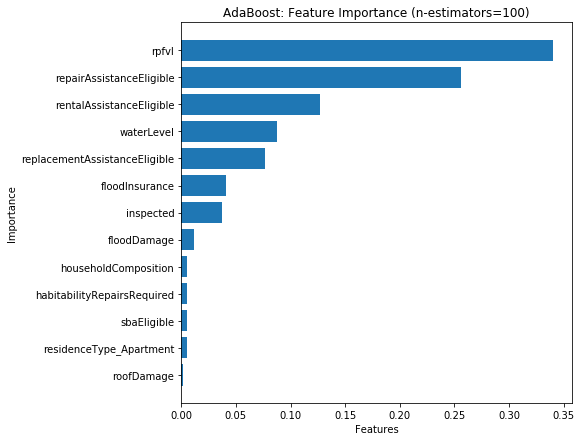

In [109]:
def plot_importance(model, data):

    # Feature importance
    df_trim = df_fema.loc[:, df_fema.columns != 'haAmount']
    importance = pd.DataFrame({'feature': df_trim.columns, 'importance': ada.feature_importances_})
    importance.sort_values(by='importance', ascending=True, inplace=True)
    trimmed_features = importance.loc[importance['importance'] > 0.001]

    # Plot feature importance
    fig, ax = plt.subplots(figsize = (7,7))
    ax.barh(trimmed_features['feature'], trimmed_features['importance'])
    ax.set_title('AdaBoost: Feature Importance (n-estimators={})'.format(ada.get_params()['n_estimators']))
    ax.set_ylabel('Importance')
    ax.set_xlabel('Features')
    
plot_importance(model=ada, data=df_fema)

### FEMA Only with Grid Search

In [173]:
def adaboost_optimizer(full_data=df):
    '''Fit GridSearchCV using AdaBoost regression for various
    parameters. Accepts input of full_data and returns (prints)
    the best model score and corresponding parameters.
    '''
    
    # Start time
    start_time = time.time()
    
    # Split the data into train and test data
    X = full_data.loc[:, full_data.columns != 'haAmount']
    y = full_data.loc[:, 'haAmount']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = True, random_state=7)

    # Parameters
    model = AdaBoostRegressor(random_state=0)
    param_grid = {'n_estimators': np.array([50, 100, 125, 150, 200]),
                  'learning_rate': np.array([0.01, 0.2, 0.5, 0.8, 1]),
                  'loss': ['linear', 'square', 'exponential']}
    
    # Fit grid search
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
    grid_search.fit(X_train, y_train)

    # Make predictions
    y_pred = grid_search.predict(X_test)

    # summarize the results of the grid search
    print('AdaBoost Regressor')
    print('Best score: {:.3f}'.format(grid_search.best_score_))
    print('Best estimator: {}'.format(grid_search.best_estimator_.n_estimators))
    print('Best learning rate: {:.2f}'.format(grid_search.best_estimator_.learning_rate))
    print('Best loss: {}'.format(grid_search.best_estimator_.loss))
    
    print('\nTime (seconds): {:.0f} '.format(time.time() - start_time))
    print('Time (minutes): {:.1f}'.format((time.time() - start_time)/60))

adaboost_optimizer(df_fema)

AdaBoost Regressor
Best score: 0.797
Best estimator: 50
Best learning rate: 0.80
Best loss: linear

Time (seconds): 5 
Time (minutes): 0.1


### FEMA with Basic Demographics 

In [112]:
def transform_demo_basic(data):
    '''Specified transforms are applied to the data in advance
    of the modeling stage, feature engineering and/or scaling,
    Accepts input of dataframe, outputs transformed dataframe.'''
    
    # Define columns
    cols = ['householdComposition', 'specialNeeds', 'homeOwnersInsurance', 'floodInsurance', 'inspected',
            'rpfvl', 'habitabilityRepairsRequired', 'destroyed', 'waterLevel', 'floodDamage',
            'foundationDamage', 'roofDamage', 'tsaEligible', 'rentalAssistanceEligible', 'repairAssistanceEligible',
            'replacementAssistanceEligible', 'sbaEligible', 'primaryResidence', 'haAmount', 'ownRent_Owner',
            'ownRent_Renter', 'ownRent_Unknown', 'residenceType_Apartment', 'residenceType_Assisted Living Facility',
            'residenceType_Boat', 'residenceType_College Dorm', 'residenceType_Condo',
            'residenceType_Correctional Facility', 'residenceType_House/Duplex', 'residenceType_Military Housing',
            'residenceType_Mobile Home', 'residenceType_Other', 'residenceType_Townhouse',
            'residenceType_Travel Trailer' ,'residenceType_Unknown', 'below_poverty_rate', 'median_earnings_total',
            'unemployed_labor_rate', 'built_1979_or_earlier_rate', 'owner_occupied_rate']
    
    # Select columns
    data = data.loc[:, cols]
    
    return(data)

In [113]:
# Transform
df_demo = transform_demo_basic(df)

# AdaBoost with basic demographics
ada_demo = adaboost_regressor(df_demo)

AdaBoost Regressor
Features: 40
R^2: 0.5758
MAE: 398.35
MSE: 2697547.24
RMSE: 1642.42


In [146]:
# Plot importance
#plot_importance(model=ada_demo, data=df_demo)

### FEMA with DVI

In [116]:
def transform_demo_dvi(data):
    '''Specified transforms are applied to the data in advance
    of the modeling stage, feature engineering and/or scaling,
    Accepts input of dataframe, outputs transformed dataframe.'''
    
    # Define columns
    cols = ['householdComposition', 'specialNeeds', 'homeOwnersInsurance', 'floodInsurance', 'inspected',
            'rpfvl', 'habitabilityRepairsRequired', 'destroyed', 'waterLevel', 'floodDamage',
            'foundationDamage', 'roofDamage', 'tsaEligible', 'rentalAssistanceEligible', 'repairAssistanceEligible',
            'replacementAssistanceEligible', 'sbaEligible', 'primaryResidence', 'haAmount', 'ownRent_Owner',
            'ownRent_Renter', 'ownRent_Unknown', 'residenceType_Apartment', 'residenceType_Assisted Living Facility',
            'residenceType_Boat', 'residenceType_College Dorm', 'residenceType_Condo',
            'residenceType_Correctional Facility', 'residenceType_House/Duplex', 'residenceType_Military Housing',
            'residenceType_Mobile Home', 'residenceType_Other', 'residenceType_Townhouse',
            'residenceType_Travel Trailer' ,'residenceType_Unknown', 'dvi']
    
    # Select columns
    data = data.loc[:, cols]
    
    return(data)

In [117]:
# Transform
df_dvi = transform_demo_dvi(df)

# AdaBoost with basic demographics
ada_dvi = adaboost_regressor(transform_demo_dvi(df))

AdaBoost Regressor
Features: 36
R^2: 0.6246
MAE: 364.50
MSE: 2374171.35
RMSE: 1540.83


In [147]:
# Plot importance
#plot_importance(model=ada_dvi, data=df_dvi)

In [131]:
np.arange(100,300,50)

array([100, 150, 200, 250])

In [140]:
[50, 100]

[50, 100]

## Scrap Code

In [ ]:
## Full Data - Dmensionality Reduction

# Check vars in index
#print(df.columns)

# Check for NaNs
#trainDf.isna().any()